In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

#set random seed and percentage of test data
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]

Using TensorFlow backend.


In [2]:
def normalize(ar):
    ar -= ar.mean()
    ar /= ar.std()
    return ar
        
def raw_to_data(df):
    df_copy = df.copy()
    #df_copy = pd.get_dummies(df_copy, columns=['category', 'nationality', 'is_pep'])
    for col in ['category', 'nationality', 'is_pep']:
        df_copy.drop(col, axis=1, inplace=True)
    for col in ['turnover', 'transaction_count', 'io_ratio', 'age', 'inactive_days_average', 'inactive_days_max', 'n_of_accounts', 'distinct_counterparties', 'channel_risk', 'atm_withdrawal', 'atm_deposit']:
        df_copy[col] = StandardScaler().fit_transform(df_copy[col].values.reshape(-1, 1))
    return df_copy

In [3]:
test_x = pd.read_csv("/floyd/input/data/test.csv", index_col=0)

test_x.head()

,category,turnover,transaction_count,io_ratio,age,nationality,is_pep,inactive_days_average,inactive_days_max,n_of_accounts,distinct_counterparties,channel_risk,atm_withdrawal,atm_deposit
customer,,,,,,,,,,,,,,
91000000,0,1235859.85,1.0,0.00,64.0,33,0,106.42,107.0,2,1.0,0.046108,1235859.85,12549.438865
91000001,1,53087.97,3.0,0.00,0.0,172,0,69.28,139.0,1,1.0,0.414826,53087.97,116.106050
91000002,0,22003.25,4.0,0.25,41.0,33,0,30.94,62.0,2,1.0,0.030105,1066.98,106.434228
91000003,0,72947.07,4.0,0.50,16.0,94,0,24.19,97.0,2,1.0,0.025249,16701.34,106.455505
91000004,0,9964.06,1.0,0.00,46.0,50,0,47.84,48.0,2,1.0,0.083395,9964.06,118.541699


In [4]:
raw_train = pd.read_csv("/floyd/input/data/train.csv", index_col=0) #unzip and read in data downloaded to the local directory
raw_train.head(n=5) #just to check you imported the dataset properly

,category,suspicious,turnover,transaction_count,io_ratio,age,nationality,is_pep,inactive_days_average,inactive_days_max,n_of_accounts,distinct_counterparties,channel_risk,atm_withdrawal,atm_deposit
customer,,,,,,,,,,,,,,,
90000000,0,0,734958.58,7.0,0.142857,79.0,134,0,24.63,124.0,3,6.0,0.128703,215959.85,832.364854
90000001,1,0,1009400.35,2.0,0.500000,0.0,33,0,78.49,79.0,3,1.0,0.635584,53.97,34.752298
90000002,0,0,11051.68,3.0,0.666667,77.0,191,0,35.74,72.0,2,1.0,0.138152,1632.91,17.323031
90000003,0,0,31193.29,81.0,0.308642,77.0,50,0,2.05,95.0,2,2.0,0.333904,3203.10,50.945281
90000004,0,0,205489.77,1.0,1.000000,39.0,172,0,147.53,148.0,4,1.0,0.341578,5626.65,0.000000


In [5]:
raw_train.shape

(1000000, 15)

In [6]:
raw_train.isnull().values.any() #check to see if any values are null, which there are not


False

In [7]:
pd.value_counts(raw_train['suspicious'], sort = True)

0    990913
1      9087
Name: suspicious, dtype: int64

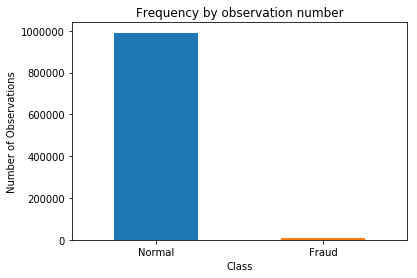

In [8]:
count_classes = pd.value_counts(raw_train['suspicious'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [9]:
normal_df = raw_train[raw_train.suspicious == 0] #save normal_df observations into a separate df
fraud_df = raw_train[raw_train.suspicious == 1] #do the same for frauds

In [10]:
normal_df.turnover.describe()


count    9.909130e+05
mean     1.446246e+07
std      2.675262e+08
min      0.000000e+00
25%      4.050807e+04
50%      1.533517e+05
75%      4.548039e+05
max      7.968697e+10
Name: turnover, dtype: float64

In [11]:
fraud_df.turnover.describe()


count    9.087000e+03
mean     1.929921e+07
std      4.024280e+08
min      1.500000e-01
25%      2.123016e+05
50%      5.510467e+05
75%      1.416317e+06
max      3.313022e+10
Name: turnover, dtype: float64

In [12]:
X_whole = raw_to_data(raw_train)
X_whole.head()

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,suspicious,turnover,transaction_count,io_ratio,age,inactive_days_average,inactive_days_max,n_of_accounts,distinct_counterparties,channel_risk,atm_withdrawal,atm_deposit
customer,,,,,,,,,,,,
90000000,0,-0.051184,-0.354459,-0.570636,1.751378,-0.410653,0.115157,1.003269,0.058982,-0.730227,-0.013012,-0.035499
90000001,0,-0.050164,-0.465353,0.575386,-1.488590,0.608882,-0.455456,1.003269,-0.319046,2.300112,-0.014998,-0.036057
90000002,0,-0.053875,-0.443175,1.110196,1.669353,-0.200348,-0.544218,0.001759,-0.319046,-0.673743,-0.014983,-0.036069
90000003,0,-0.053800,1.286776,-0.038656,1.669353,-0.838078,-0.252571,0.001759,-0.243441,0.496544,-0.014969,-0.036046
90000004,0,-0.053152,-0.487532,2.179817,0.110888,1.915764,0.419483,2.004779,-0.319046,0.542422,-0.014947,-0.036081


In [13]:
X_whole.shape

(1000000, 12)

In [14]:
X_train, X_val = train_test_split(X_whole, test_size=TEST_PCT, random_state=RANDOM_SEED)
validation_customer_ids = pd.DataFrame(X_val.index.values)

X_train = X_train[X_train.suspicious == 0] #where normal transactions
X_train = X_train.drop(['suspicious'], axis=1) #drop the class column


y_val = X_val['suspicious'] #save the class column for the test set
X_val = X_val.drop(['suspicious'], axis=1) #drop the class column

X_train = X_train.values #transform to ndarray
X_val = X_val.values

In [15]:
X_train.shape, X_val.shape

((792750, 11), (200000, 11))

In [16]:
validation_customer_ids.to_csv('./validation_customer_ids.csv', header=False, index=False)

In [26]:
nb_epoch = 100
batch_size = 32
input_dim = X_train.shape[1]
encoding_dim = 8
hidden_dim = encoding_dim // 2
learning_rate = 1e-4

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
encoder = Dense(hidden_dim//2, activation="relu")(encoder)
decoder = Dense(hidden_dim//2, activation='relu')(encoder)
decoder = Dense(hidden_dim, activation='relu')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [27]:
import os.path
def get_name(i=0, unique=True):
    fname = f'autoencoder_fraud_{nb_epoch}_{batch_size}_{encoding_dim}_{i}'
    if not unique or not os.path.isfile(f'{fname}.h5'):
        return fname
    else:
        return get_name(i+1)

In [28]:
#from helpers_keras import f1, precision, recall

fname = get_name()

autoencoder.compile(metrics=["accuracy"],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath=f"{fname}.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir=f'./logs_{fname}',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

In [ ]:
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 792750 samples, validate on 200000 samples
Epoch 1/100
792750/792750 [==============================] - 115s 145us/step - loss: 0.8064 - acc: 0.2849 - val_loss: 0.6682 - val_acc: 0.3329
Epoch 2/100
 37152/792750 [>.............................] - ETA: 1:42 - loss: 0.7835 - acc: 0.3275

In [ ]:
#from helpers_keras import f1, precision, recall

In [23]:
1 + 1

2

In [118]:
1+1

2

In [27]:
autoencoder_trained = load_model(f'{get_name(unique=False)}.h5')

In [28]:
predictions = autoencoder_trained.predict(X_val)

In [29]:
mse = np.mean(np.power(X_val - predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_val})
error_df = error_df.sort_values('Reconstruction_error')
error_df.describe()

,Reconstruction_error,True_class
count,200000.000000,200000.000000
mean,0.693262,0.009185
std,15.565393,0.095397
min,0.028185,0.000000
25%,0.273617,0.000000
50%,0.405013,0.000000
75%,0.631034,0.000000
max,5353.639188,1.000000


In [31]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

NameError: name 'history' is not defined

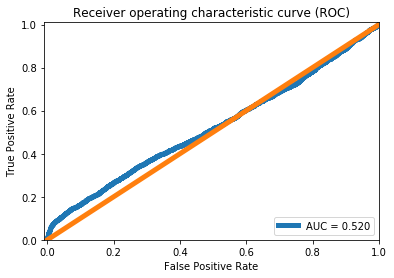

In [32]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

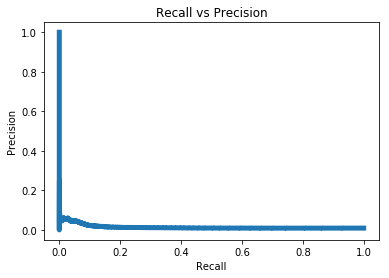

In [33]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

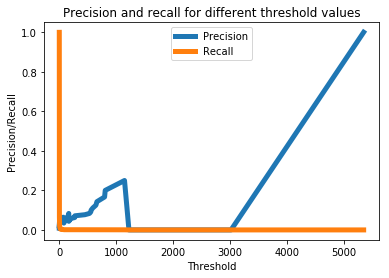

In [34]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

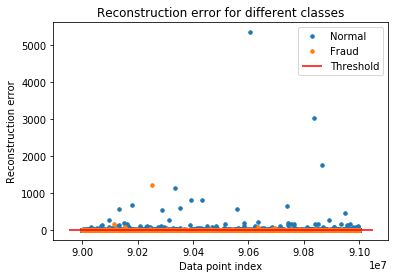

In [35]:
threshold_fixed = 0.6
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

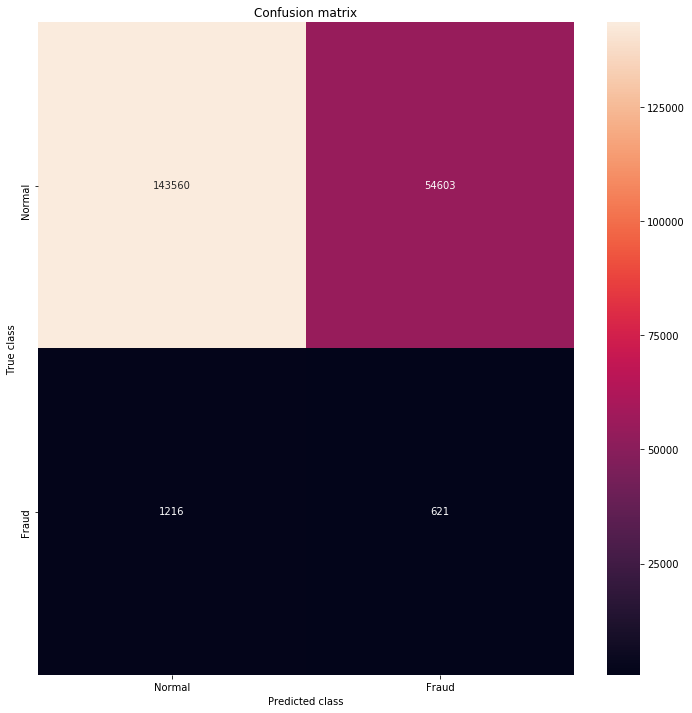

In [36]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [179]:
pred_df = pd.DataFrame({'customer':validation_customer_ids[0], 'pred':mse}).set_index('customer').sort_values('pred')

In [180]:
pred_df.head()

,pred
customer,
90805307,0.022396
90593639,0.024397
90478307,0.024931
90166741,0.025129
90869420,0.025575


In [161]:
final_results = pd.merge(pred_df, y_val.to_frame(), how='inner', left_index=True, right_index=True)
final_results.head()

,pred,suspicious
customer,,
90805307,0.022396,1
90593639,0.024397,0
90478307,0.024931,0
90166741,0.025129,0
90869420,0.025575,0


In [166]:
(final_results['pred'] > 0.5).sum()

23557

In [171]:
((final_results['pred'] > 0.8) == final_results['suspicious']).sum() / 2000

94.3225

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


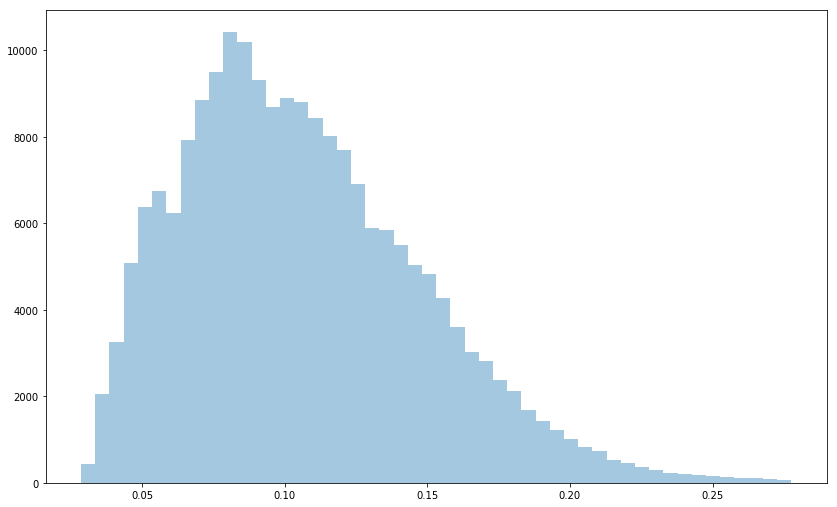

In [74]:
sns.distplot(pred.sort_values(0).values[:-1000], kde=False)
#plt.yscale('log')

In [75]:
y_val.sum()

1837

In [ ]:
pred.values[:-1000]